## Time series Forecasting

In [32]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

In [33]:
import pandas as pd

# df = pd.read_csv("BTC_USD_2014-11-04_2022-02-09-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", parse_dates=["Date"], index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [35]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "price"})
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [36]:
len(bitcoin_prices), bitcoin_prices.shape

(2787, (2787, 1))

In [37]:
from sklearn.model_selection import train_test_split
X = bitcoin_prices.index
y = bitcoin_prices.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [38]:
type(X_train)

pandas.core.indexes.datetimes.DatetimeIndex

In [39]:
y

Date
2013-10-01      123.654990
2013-10-02      125.455000
2013-10-03      108.584830
2013-10-04      118.674660
2013-10-05      121.338660
                  ...     
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: price, Length: 2787, dtype: float64

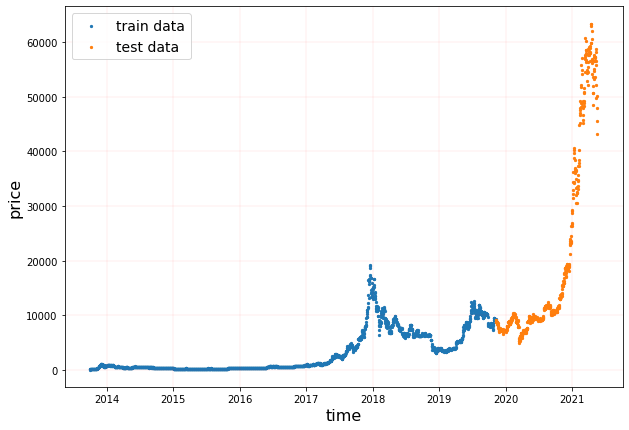

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.grid(color='r', linestyle='-', linewidth=.07)
plt.scatter(X_train, y_train, s=5)
plt.scatter(X_test, y_test, s=5)
plt.xlabel("time", fontsize=16)
plt.ylabel("price", fontsize=16)
plt.legend(("train data", "test data"), fontsize=14)
plt.show()

In [41]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)
    
    mase = mae / mae_naive_no_season
  
    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [42]:
prices = bitcoin_prices["price"].to_numpy()
prices[:5]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866])

In [43]:
len(prices), type(prices)

(2787, numpy.ndarray)

In [44]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

def make_train_test_split(nparray: np.ndarray, window:int, horizon:int, test_size=0.2)-> tuple:
    tscv = TimeSeriesSplit(max_train_size=7, test_size=horizon, n_splits=len(nparray) - window)
    print(tscv)
    
    _train_list = []
    _test_list = []
    
    for train_index, test_index in tscv.split(nparray):
        #print("TRAIN:", train_index, "TEST:", test_index)
        _train_list.append(nparray[train_index])
        _test_list.append(nparray[test_index])
        
    windows = np.asarray(_train_list)
    labels = np.asarray(_test_list)
    
    split_size = int(len(nparray) * (1-test_size)) # this will default to 80% train/20% test
    
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    
    return train_windows, test_windows, train_labels, test_labels

In [45]:
import numpy as np

train_windows, test_windows, train_labels, test_labels = make_train_test_split(nparray=prices, window=7, horizon=1)

TimeSeriesSplit(gap=0, max_train_size=7, n_splits=2780, test_size=1)


In [46]:
for i in range(0, 5):
    print(f"input: {train_windows[i]}, label: {train_labels[i]}")

input: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], label: [123.033]
input: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], label: [124.049]
input: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], label: [125.96116]
input: [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116], label: [125.27966]
input: [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966], label: [125.9275]


In [47]:
import os
import tensorflow as tf

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              save_best_only=True,
                                              verbose=0)

### Model 1: Dense model (window = 7, horizon = 1)

In [48]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam

WINDOW = 7
HORIZON = 1

tf.random.set_seed(42)

model_1 = Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear") 
], name="model_1_dense")

model_1.compile(loss=mae,
                optimizer=Adam(),
                metrics=["mae"])

In [49]:
model_1.get_config()

{'name': 'model_1_dense',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_4',
    'trainable': True,
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_5',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'linear',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}}

In [50]:
history_1 = model_1.fit(train_windows,
                        train_labels,
                        epochs=100,
                        verbose=1,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
69/70 [============================>.] - ETA: 0s - loss: 343.4139 - mae: 343.4139  INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 1s 6ms/step - loss: 343.7033 - mae: 343.7033 - val_loss: 922.5333 - val_mae: 922.5333
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 161.0674 - mae: 161.0674 - val_loss: 937.6246 - val_mae: 937.6246
Epoch 3/100
37/70 [==============>...............] - ETA: 0s - loss: 156.0300 - mae: 156.0300INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 148.2369 - mae: 148.2369 - val_loss: 776.7939 - val_mae: 776.7939
Epoch 4/100
34/70 [=============>................] - ETA: 0s - loss: 134.4023 - mae: 134.4023INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 6ms/step - loss: 132.3288 - mae: 132.3288 - val_loss: 683.6370 - val_mae: 683.6370
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 131.4117 - mae: 131.4117 - val_loss: 1012.5534 - val_mae: 1012.5534
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 136.6220 - mae: 136.6220 - val_loss: 685.4259 - val_mae: 685.4259
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 122.9630 - mae: 122.9630 - val_loss: 703.2964 - val_mae: 703.2964
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 123.1799 - mae: 123.1799 - val_loss: 817.0975 - val_mae: 817.0975
Epoch 9/100
38/70 [===============>..............] - ETA: 0s - loss: 117.7140 - mae: 117.7140INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 122.1537 - mae: 122.1537 - val_loss: 619.8591 - val_mae: 619.8591
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 118.6951 - mae: 118.6951 - val_loss: 635.3211 - val_mae: 635.3211
Epoch 11/100
70/70 [==============================] - 0s 2ms/step - loss: 118.5260 - mae: 118.5260 - val_loss: 630.0175 - val_mae: 630.0175
Epoch 12/100
70/70 [==============================] - 0s 2ms/step - loss: 116.0763 - mae: 116.0763 - val_loss: 639.2427 - val_mae: 639.2427
Epoch 13/100
70/70 [==============================] - 0s 2ms/step - loss: 113.1648 - mae: 113.1648 - val_loss: 629.2646 - val_mae: 629.2646
Epoch 14/100
43/70 [=================>............] - ETA: 0s - loss: 120.8878 - mae: 120.8878INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 118.5675 - mae: 118.5675 - val_loss: 606.6513 - val_mae: 606.6513
Epoch 15/100
70/70 [==============================] - 0s 2ms/step - loss: 114.3830 - mae: 114.3830 - val_loss: 656.1324 - val_mae: 656.1324
Epoch 16/100
70/70 [==============================] - 0s 2ms/step - loss: 129.6604 - mae: 129.6604 - val_loss: 732.4889 - val_mae: 732.4889
Epoch 17/100
70/70 [==============================] - 0s 2ms/step - loss: 120.1646 - mae: 120.1646 - val_loss: 609.2922 - val_mae: 609.2922
Epoch 18/100
70/70 [==============================] - 0s 2ms/step - loss: 120.5293 - mae: 120.5293 - val_loss: 681.2451 - val_mae: 681.2451
Epoch 19/100
70/70 [==============================] - 0s 2ms/step - loss: 115.0861 - mae: 115.0861 - val_loss: 698.1938 - val_mae: 698.1938
Epoch 20/100
70/70 [==============================] - 0s 2ms/step - loss: 131.7963 - mae: 131.7963 - val_loss: 778.7521 - val_mae: 778.7521
Epoch 21/100
39/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 117.5669 - mae: 117.5669 - val_loss: 582.2695 - val_mae: 582.2695
Epoch 22/100
70/70 [==============================] - 0s 2ms/step - loss: 113.7481 - mae: 113.7481 - val_loss: 655.1566 - val_mae: 655.1566
Epoch 23/100
70/70 [==============================] - 0s 2ms/step - loss: 116.2084 - mae: 116.2084 - val_loss: 588.9680 - val_mae: 588.9680
Epoch 24/100
70/70 [==============================] - 0s 2ms/step - loss: 117.0473 - mae: 117.0473 - val_loss: 601.5239 - val_mae: 601.5239
Epoch 25/100
70/70 [==============================] - 0s 2ms/step - loss: 117.6968 - mae: 117.6968 - val_loss: 583.7342 - val_mae: 583.7342
Epoch 26/100
70/70 [==============================] - 0s 2ms/step - loss: 122.0995 - mae: 122.0995 - val_loss: 718.0260 - val_mae: 718.0260
Epoch 27/100
70/70 [==============================] - 0s 2ms/step - loss: 122.9913 - mae: 122.9913 - val_loss: 603.4142 - val_mae: 603.4142
Epoch 28/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 112.5566 - mae: 112.5566 - val_loss: 574.9615 - val_mae: 574.9615
Epoch 41/100
70/70 [==============================] - 0s 2ms/step - loss: 114.4254 - mae: 114.4254 - val_loss: 696.5612 - val_mae: 696.5612
Epoch 42/100
42/70 [=================>............] - ETA: 0s - loss: 125.6352 - mae: 125.6352INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 120.0147 - mae: 120.0147 - val_loss: 572.2584 - val_mae: 572.2584
Epoch 43/100
70/70 [==============================] - 0s 2ms/step - loss: 110.9819 - mae: 110.9819 - val_loss: 585.6960 - val_mae: 585.6960
Epoch 44/100
70/70 [==============================] - 0s 2ms/step - loss: 112.9197 - mae: 112.9197 - val_loss: 818.9876 - val_mae: 818.9876
Epoch 45/100
70/70 [==============================] - 0s 2ms/step - loss: 113.4170 - mae: 113.4170 - val_loss: 653.9536 - val_mae: 653.9536
Epoch 46/100
70/70 [==============================] - 0s 2ms/step - loss: 113.1074 - mae: 113.1074 - val_loss: 573.8594 - val_mae: 573.8594
Epoch 47/100
70/70 [==============================] - 0s 2ms/step - loss: 113.4201 - mae: 113.4201 - val_loss: 836.2509 - val_mae: 836.2509
Epoch 48/100
70/70 [==============================] - 0s 2ms/step - loss: 126.8303 - mae: 126.8303 - val_loss: 671.5677 - val_mae: 671.5677
Epoch 49/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 112.3857 - mae: 112.3857 - val_loss: 571.0112 - val_mae: 571.0112
Epoch 55/100
70/70 [==============================] - 0s 2ms/step - loss: 113.0411 - mae: 113.0411 - val_loss: 577.6389 - val_mae: 577.6389
Epoch 56/100
70/70 [==============================] - 0s 2ms/step - loss: 111.5038 - mae: 111.5038 - val_loss: 636.0012 - val_mae: 636.0012
Epoch 57/100
70/70 [==============================] - 0s 2ms/step - loss: 110.3537 - mae: 110.3537 - val_loss: 581.6431 - val_mae: 581.6431
Epoch 58/100
70/70 [==============================] - 0s 2ms/step - loss: 116.5816 - mae: 116.5816 - val_loss: 576.2189 - val_mae: 576.2189
Epoch 59/100
70/70 [==============================] - 0s 2ms/step - loss: 113.1792 - mae: 113.1792 - val_loss: 581.1438 - val_mae: 581.1438
Epoch 60/100
70/70 [==============================] - 0s 2ms/step - loss: 111.4110 - mae: 111.4110 - val_loss: 607.2144 - val_mae: 607.2144
Epoch 61/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 108.0216 - mae: 108.0216 - val_loss: 569.7256 - val_mae: 569.7256
Epoch 65/100
70/70 [==============================] - 0s 2ms/step - loss: 110.2716 - mae: 110.2716 - val_loss: 782.4759 - val_mae: 782.4759
Epoch 66/100
70/70 [==============================] - 0s 2ms/step - loss: 111.4064 - mae: 111.4064 - val_loss: 674.9920 - val_mae: 674.9920
Epoch 67/100
70/70 [==============================] - 0s 2ms/step - loss: 114.1350 - mae: 114.1350 - val_loss: 588.3494 - val_mae: 588.3494
Epoch 68/100
70/70 [==============================] - 0s 2ms/step - loss: 111.7369 - mae: 111.7369 - val_loss: 578.6490 - val_mae: 578.6490
Epoch 69/100
70/70 [==============================] - 0s 2ms/step - loss: 114.1871 - mae: 114.1871 - val_loss: 592.0038 - val_mae: 592.0038
Epoch 70/100
70/70 [==============================] - 0s 2ms/step - loss: 122.6858 - mae: 122.6858 - val_loss: 705.4669 - val_mae: 705.4669
Epoch 71/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


70/70 [==============================] - 0s 5ms/step - loss: 119.8069 - mae: 119.8069 - val_loss: 569.1689 - val_mae: 569.1689
Epoch 83/100
70/70 [==============================] - 0s 2ms/step - loss: 112.6206 - mae: 112.6206 - val_loss: 630.1481 - val_mae: 630.1481
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 112.0751 - mae: 112.0751 - val_loss: 611.7151 - val_mae: 611.7151
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 111.3090 - mae: 111.3090 - val_loss: 577.9584 - val_mae: 577.9584
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 108.2499 - mae: 108.2499 - val_loss: 580.2400 - val_mae: 580.2400
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 109.5042 - mae: 109.5042 - val_loss: 704.2545 - val_mae: 704.2545
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 114.6280 - mae: 114.6280 - val_loss: 611.9465 - val_mae: 611.9465
Epoch 89/100
70/70 [=============

In [51]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 649.0461 - mae: 649.0461


[649.046142578125, 649.046142578125]

<AxesSubplot:>

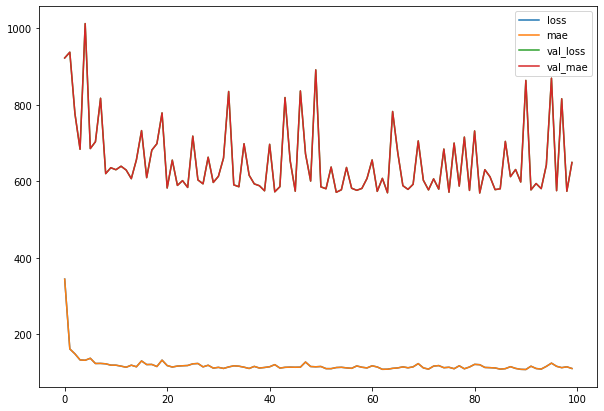

In [52]:
pd.DataFrame(history_1.history).plot(figsize=(10, 7))

In [53]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 569.1689 - mae: 569.1689


[569.1689453125, 569.1689453125]

In [54]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model 
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [55]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(551,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8730.911 , 8670.605 , 8513.254 , 8458.148 , 8523.    , 8252.551 ,
        8112.0166, 8068.411 , 7680.6616, 7296.1685], dtype=float32)>)

In [56]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                     y_pred=model_1_preds)
model_1_results

{'mae': 569.16895,
 'mse': 1168156.8,
 'rmse': 1080.813,
 'mape': 2.5240622,
 'mase': 0.9933989}

### Model 2: Conv1D

In [57]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam

WINDOW = 7
HORIZON = 1

tf.random.set_seed(42)

model_2 = Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
    layers.Conv1D(128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON, activation="linear") 
], name="model_2_Conv1D")

model_2.compile(loss=mae,
                optimizer=Adam(),
                metrics=["mae"])

history_2 = model_2.fit(train_windows,
                        train_labels,
                        epochs=100,
                        verbose=1,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
54/70 [======================>.......] - ETA: 0s - loss: 586.6011 - mae: 586.6011  INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 11ms/step - loss: 498.5802 - mae: 498.5802 - val_loss: 1016.2603 - val_mae: 1016.2603
Epoch 2/100
55/70 [======================>.......] - ETA: 0s - loss: 171.5325 - mae: 171.5325INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 175.0822 - mae: 175.0822 - val_loss: 923.4818 - val_mae: 923.4818
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 165.9510 - mae: 165.9510 - val_loss: 1007.4684 - val_mae: 1007.4684
Epoch 4/100
59/70 [========================>.....] - ETA: 0s - loss: 165.2887 - mae: 165.2887INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 160.9738 - mae: 160.9738 - val_loss: 821.1409 - val_mae: 821.1409
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 154.2687 - mae: 154.2687 - val_loss: 893.6516 - val_mae: 893.6516
Epoch 6/100
57/70 [=======================>......] - ETA: 0s - loss: 149.9429 - mae: 149.9429INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 147.0423 - mae: 147.0423 - val_loss: 752.0245 - val_mae: 752.0245
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 134.9966 - mae: 134.9966 - val_loss: 760.9916 - val_mae: 760.9916
Epoch 8/100
60/70 [========================>.....] - ETA: 0s - loss: 130.0383 - mae: 130.0383INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 130.3542 - mae: 130.3542 - val_loss: 701.8557 - val_mae: 701.8557
Epoch 9/100
55/70 [======================>.......] - ETA: 0s - loss: 131.4963 - mae: 131.4963INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 129.4374 - mae: 129.4374 - val_loss: 674.8318 - val_mae: 674.8318
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 129.7548 - mae: 129.7548 - val_loss: 692.0575 - val_mae: 692.0575
Epoch 11/100
62/70 [=========================>....] - ETA: 0s - loss: 128.0644 - mae: 128.0644INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 0s 7ms/step - loss: 129.6379 - mae: 129.6379 - val_loss: 659.4009 - val_mae: 659.4009
Epoch 12/100
70/70 [==============================] - 0s 2ms/step - loss: 130.6689 - mae: 130.6689 - val_loss: 677.9120 - val_mae: 677.9120
Epoch 13/100
70/70 [==============================] - 0s 2ms/step - loss: 120.5708 - mae: 120.5708 - val_loss: 665.0255 - val_mae: 665.0255
Epoch 14/100
57/70 [=======================>......] - ETA: 0s - loss: 126.2146 - mae: 126.2146INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 121.9869 - mae: 121.9869 - val_loss: 620.4457 - val_mae: 620.4457
Epoch 15/100
70/70 [==============================] - 0s 2ms/step - loss: 129.4469 - mae: 129.4469 - val_loss: 850.4518 - val_mae: 850.4518
Epoch 16/100
70/70 [==============================] - 0s 2ms/step - loss: 125.1787 - mae: 125.1787 - val_loss: 748.5709 - val_mae: 748.5709
Epoch 17/100
70/70 [==============================] - 0s 2ms/step - loss: 118.9047 - mae: 118.9047 - val_loss: 621.1331 - val_mae: 621.1331
Epoch 18/100
70/70 [==============================] - 0s 2ms/step - loss: 121.0349 - mae: 121.0349 - val_loss: 627.3807 - val_mae: 627.3807
Epoch 19/100
70/70 [==============================] - 0s 2ms/step - loss: 123.1282 - mae: 123.1282 - val_loss: 860.3013 - val_mae: 860.3013
Epoch 20/100
70/70 [==============================] - 0s 2ms/step - loss: 128.1976 - mae: 128.1976 - val_loss: 756.0247 - val_mae: 756.0247
Epoch 21/100
57/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 118.8059 - mae: 118.8059 - val_loss: 617.5305 - val_mae: 617.5305
Epoch 22/100
70/70 [==============================] - 0s 3ms/step - loss: 113.9758 - mae: 113.9758 - val_loss: 704.2343 - val_mae: 704.2343
Epoch 23/100
56/70 [=======================>......] - ETA: 0s - loss: 125.9300 - mae: 125.9300INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 125.3076 - mae: 125.3076 - val_loss: 596.8085 - val_mae: 596.8085
Epoch 24/100
70/70 [==============================] - 0s 2ms/step - loss: 123.2907 - mae: 123.2907 - val_loss: 614.3029 - val_mae: 614.3029
Epoch 25/100
64/70 [==========================>...] - ETA: 0s - loss: 119.2088 - mae: 119.2088INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 0s 7ms/step - loss: 117.9437 - mae: 117.9437 - val_loss: 587.4826 - val_mae: 587.4826
Epoch 26/100
70/70 [==============================] - 0s 2ms/step - loss: 118.5938 - mae: 118.5938 - val_loss: 706.6486 - val_mae: 706.6486
Epoch 27/100
70/70 [==============================] - 0s 2ms/step - loss: 122.7000 - mae: 122.7000 - val_loss: 601.7245 - val_mae: 601.7245
Epoch 28/100
63/70 [==========================>...] - ETA: 0s - loss: 120.8552 - mae: 120.8552INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 9ms/step - loss: 118.2329 - mae: 118.2329 - val_loss: 585.6036 - val_mae: 585.6036
Epoch 29/100
70/70 [==============================] - 0s 2ms/step - loss: 119.6519 - mae: 119.6519 - val_loss: 750.2293 - val_mae: 750.2293
Epoch 30/100
61/70 [=========================>....] - ETA: 0s - loss: 121.4045 - mae: 121.4045INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 9ms/step - loss: 118.5963 - mae: 118.5963 - val_loss: 582.7057 - val_mae: 582.7057
Epoch 31/100
55/70 [======================>.......] - ETA: 0s - loss: 123.0782 - mae: 123.0782INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 117.0917 - mae: 117.0917 - val_loss: 581.7856 - val_mae: 581.7856
Epoch 32/100
70/70 [==============================] - 0s 2ms/step - loss: 111.5798 - mae: 111.5798 - val_loss: 653.0148 - val_mae: 653.0148
Epoch 33/100
70/70 [==============================] - 0s 2ms/step - loss: 123.8082 - mae: 123.8082 - val_loss: 640.9718 - val_mae: 640.9718
Epoch 34/100
70/70 [==============================] - 0s 2ms/step - loss: 114.9707 - mae: 114.9707 - val_loss: 634.2855 - val_mae: 634.2855
Epoch 35/100
70/70 [==============================] - 0s 2ms/step - loss: 116.8908 - mae: 116.8908 - val_loss: 594.4246 - val_mae: 594.4246
Epoch 36/100
70/70 [==============================] - 0s 2ms/step - loss: 115.2256 - mae: 115.2256 - val_loss: 776.5801 - val_mae: 776.5801
Epoch 37/100
70/70 [==============================] - 0s 2ms/step - loss: 114.5415 - mae: 114.5415 - val_loss: 615.5759 - val_mae: 615.5759
Epoch 38/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 0s 7ms/step - loss: 113.6222 - mae: 113.6222 - val_loss: 580.6447 - val_mae: 580.6447
Epoch 41/100
70/70 [==============================] - 0s 2ms/step - loss: 111.5665 - mae: 111.5665 - val_loss: 596.0848 - val_mae: 596.0848
Epoch 42/100
70/70 [==============================] - 0s 2ms/step - loss: 117.3335 - mae: 117.3335 - val_loss: 607.4484 - val_mae: 607.4484
Epoch 43/100
70/70 [==============================] - 0s 2ms/step - loss: 109.5196 - mae: 109.5196 - val_loss: 582.1223 - val_mae: 582.1223
Epoch 44/100
70/70 [==============================] - 0s 3ms/step - loss: 118.0680 - mae: 118.0680 - val_loss: 716.9860 - val_mae: 716.9860
Epoch 45/100
70/70 [==============================] - 0s 2ms/step - loss: 116.3432 - mae: 116.3432 - val_loss: 592.2442 - val_mae: 592.2442
Epoch 46/100
70/70 [==============================] - 0s 2ms/step - loss: 112.5501 - mae: 112.5501 - val_loss: 589.4237 - val_mae: 589.4237
Epoch 47/100
56/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 109.4527 - mae: 109.4527 - val_loss: 576.5160 - val_mae: 576.5160
Epoch 48/100
70/70 [==============================] - 0s 2ms/step - loss: 116.9491 - mae: 116.9491 - val_loss: 693.1686 - val_mae: 693.1686
Epoch 49/100
70/70 [==============================] - 0s 2ms/step - loss: 114.5008 - mae: 114.5008 - val_loss: 633.4564 - val_mae: 633.4564
Epoch 50/100
70/70 [==============================] - 0s 2ms/step - loss: 114.5110 - mae: 114.5110 - val_loss: 699.5571 - val_mae: 699.5571
Epoch 51/100
70/70 [==============================] - 0s 2ms/step - loss: 111.8733 - mae: 111.8733 - val_loss: 636.2451 - val_mae: 636.2451
Epoch 52/100
70/70 [==============================] - 0s 2ms/step - loss: 114.2518 - mae: 114.2518 - val_loss: 649.7776 - val_mae: 649.7776
Epoch 53/100
70/70 [==============================] - 0s 2ms/step - loss: 120.0235 - mae: 120.0235 - val_loss: 662.1032 - val_mae: 662.1032
Epoch 54/100
60/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 115.4358 - mae: 115.4358 - val_loss: 571.6324 - val_mae: 571.6324
Epoch 55/100
70/70 [==============================] - 0s 2ms/step - loss: 112.3367 - mae: 112.3367 - val_loss: 573.2380 - val_mae: 573.2380
Epoch 56/100
70/70 [==============================] - 0s 2ms/step - loss: 118.6434 - mae: 118.6434 - val_loss: 615.3746 - val_mae: 615.3746
Epoch 57/100
70/70 [==============================] - 0s 2ms/step - loss: 110.5841 - mae: 110.5841 - val_loss: 606.5143 - val_mae: 606.5143
Epoch 58/100
70/70 [==============================] - 0s 2ms/step - loss: 117.0054 - mae: 117.0054 - val_loss: 602.6879 - val_mae: 602.6879
Epoch 59/100
70/70 [==============================] - 0s 3ms/step - loss: 114.7835 - mae: 114.7835 - val_loss: 589.3839 - val_mae: 589.3839
Epoch 60/100
70/70 [==============================] - 0s 3ms/step - loss: 113.8273 - mae: 113.8273 - val_loss: 607.4486 - val_mae: 607.4486
Epoch 61/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 110.3237 - mae: 110.3237 - val_loss: 567.1567 - val_mae: 567.1567
Epoch 69/100
70/70 [==============================] - 0s 2ms/step - loss: 113.8641 - mae: 113.8641 - val_loss: 632.4775 - val_mae: 632.4775
Epoch 70/100
70/70 [==============================] - 0s 2ms/step - loss: 123.8711 - mae: 123.8711 - val_loss: 613.1041 - val_mae: 613.1041
Epoch 71/100
70/70 [==============================] - 0s 2ms/step - loss: 110.3880 - mae: 110.3880 - val_loss: 661.2249 - val_mae: 661.2249
Epoch 72/100
70/70 [==============================] - 0s 2ms/step - loss: 107.5926 - mae: 107.5926 - val_loss: 581.5438 - val_mae: 581.5438
Epoch 73/100
70/70 [==============================] - 0s 2ms/step - loss: 119.3622 - mae: 119.3622 - val_loss: 640.8325 - val_mae: 640.8325
Epoch 74/100
70/70 [==============================] - 0s 2ms/step - loss: 115.2913 - mae: 115.2913 - val_loss: 589.9178 - val_mae: 589.9178
Epoch 75/100
70/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 7ms/step - loss: 119.2956 - mae: 119.2956 - val_loss: 567.1501 - val_mae: 567.1501
Epoch 83/100
70/70 [==============================] - 0s 2ms/step - loss: 112.0784 - mae: 112.0784 - val_loss: 660.2622 - val_mae: 660.2622
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 113.0111 - mae: 113.0111 - val_loss: 613.1071 - val_mae: 613.1071
Epoch 85/100
70/70 [==============================] - 0s 3ms/step - loss: 111.3998 - mae: 111.3998 - val_loss: 572.8730 - val_mae: 572.8730
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 107.7746 - mae: 107.7746 - val_loss: 619.5070 - val_mae: 619.5070
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 111.8919 - mae: 111.8919 - val_loss: 655.6433 - val_mae: 655.6433
Epoch 88/100
70/70 [==============================] - 0s 2ms/step - loss: 112.8543 - mae: 112.8543 - val_loss: 571.5901 - val_mae: 571.5901
Epoch 89/100
62/70 [=============

INFO:tensorflow:Assets written to: model_experiments/model_2_Conv1D/assets


70/70 [==============================] - 1s 8ms/step - loss: 109.4055 - mae: 109.4055 - val_loss: 566.5204 - val_mae: 566.5204
Epoch 90/100
70/70 [==============================] - 0s 2ms/step - loss: 107.8768 - mae: 107.8768 - val_loss: 595.1240 - val_mae: 595.1240
Epoch 91/100
70/70 [==============================] - 0s 3ms/step - loss: 107.3025 - mae: 107.3025 - val_loss: 838.9830 - val_mae: 838.9830
Epoch 92/100
70/70 [==============================] - 0s 3ms/step - loss: 117.2081 - mae: 117.2081 - val_loss: 597.8840 - val_mae: 597.8840
Epoch 93/100
70/70 [==============================] - 0s 3ms/step - loss: 111.7916 - mae: 111.7916 - val_loss: 577.8279 - val_mae: 577.8279
Epoch 94/100
70/70 [==============================] - 0s 2ms/step - loss: 107.8368 - mae: 107.8368 - val_loss: 587.6602 - val_mae: 587.6602
Epoch 95/100
70/70 [==============================] - 0s 2ms/step - loss: 120.3744 - mae: 120.3744 - val_loss: 572.6644 - val_mae: 572.6644
Epoch 96/100
70/70 [=============

In [58]:
model_2.get_config()

{'name': 'model_2_Conv1D',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 7),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'lambda_2_input'}},
  {'class_name': 'Lambda',
   'config': {'name': 'lambda_2',
    'trainable': True,
    'dtype': 'float32',
    'function': ('4wEAAAAAAAAAAAAAAAEAAAAEAAAAQwAAAHMOAAAAdABqAXwAZAFkAo0CUwApA07pAQAAACkB2gRh\neGlzKQLaAnRm2gtleHBhbmRfZGltcykB2gF4qQByBgAAAPofL3RtcC9pcHlrZXJuZWxfODI4MDUv\nNjk5MjQ4Ny5wedoIPGxhbWJkYT4NAAAA8wAAAAA=\n',
     None,
     None),
    'function_type': 'lambda',
    'module': '__main__',
    'output_shape': None,
    'output_shape_type': 'raw',
    'output_shape_module': None,
    'arguments': {}}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_1',
    'trainable': True,
    'dtype': 'float32',
    'filters': 128,
    'kernel_size': (5,),
    'strides': (1,),
    'padding': 'causal',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    '

In [59]:
model_2.summary()

Model: "model_2_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


18/18 [==============================] - 0s 2ms/step - loss: 566.5204 - mae: 566.5204


{'mae': 566.52045,
 'mse': 1161522.0,
 'rmse': 1077.7393,
 'mape': 2.5242834,
 'mase': 0.9887763}

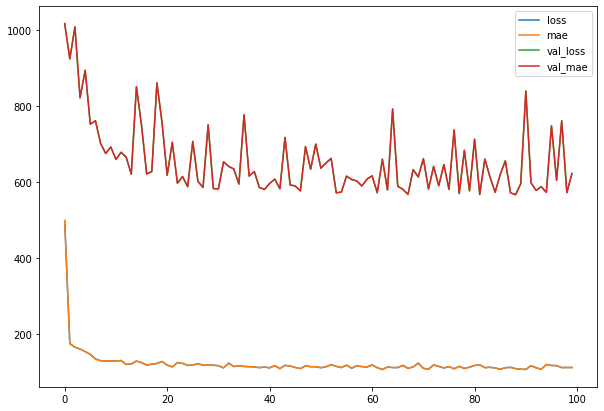

In [60]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

pd.DataFrame(history_2.history).plot(figsize=(10, 7))

# Load in saved best performing model_1 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments/" + model_2.name)
model_2.evaluate(test_windows, test_labels)

# Make predictions using model_1 on the test dataset and view the results
model_2_preds = make_preds(model_2, test_windows)


# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

### Model 3: RNN (LSTM)

In [61]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam

WINDOW_SIZE = 7
HORIZON = 1

tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu")(x)
outputs = layers.Dense(HORIZON, activation="linear")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_lstm")

model_3.compile(loss=mae,
                optimizer=Adam(),
                metrics=["mae"])

history_3 = model_3.fit(train_windows,
                        train_labels,
                        epochs=100,
                        verbose=1,
                        validation_data=(test_windows, test_labels),
                        callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
63/70 [==========================>...] - ETA: 0s - loss: 991.4950 - mae: 991.4950  INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 2s 21ms/step - loss: 915.2845 - mae: 915.2845 - val_loss: 1038.3741 - val_mae: 1038.3741
Epoch 2/100
55/70 [======================>.......] - ETA: 0s - loss: 172.8376 - mae: 172.8376INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 18ms/step - loss: 175.4903 - mae: 175.4903 - val_loss: 951.7239 - val_mae: 951.7239
Epoch 3/100
70/70 [==============================] - 0s 4ms/step - loss: 169.0302 - mae: 169.0302 - val_loss: 966.1183 - val_mae: 966.1183
Epoch 4/100
69/70 [============================>.] - ETA: 0s - loss: 167.0732 - mae: 167.0732INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 18ms/step - loss: 166.4377 - mae: 166.4377 - val_loss: 921.1736 - val_mae: 921.1736
Epoch 5/100
63/70 [==========================>...] - ETA: 0s - loss: 156.4700 - mae: 156.4700INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 18ms/step - loss: 157.3706 - mae: 157.3706 - val_loss: 835.3214 - val_mae: 835.3214
Epoch 6/100
62/70 [=========================>....] - ETA: 0s - loss: 152.7187 - mae: 152.7187INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 20ms/step - loss: 149.7184 - mae: 149.7184 - val_loss: 815.7233 - val_mae: 815.7233
Epoch 7/100
62/70 [=========================>....] - ETA: 0s - loss: 145.8226 - mae: 145.8226INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 147.0569 - mae: 147.0569 - val_loss: 781.0246 - val_mae: 781.0246
Epoch 8/100
54/70 [======================>.......] - ETA: 0s - loss: 141.3375 - mae: 141.3375INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 141.7138 - mae: 141.7138 - val_loss: 759.9946 - val_mae: 759.9946
Epoch 9/100
57/70 [=======================>......] - ETA: 0s - loss: 139.8923 - mae: 139.8923INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 19ms/step - loss: 137.0310 - mae: 137.0310 - val_loss: 743.9283 - val_mae: 743.9283
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - loss: 135.3138 - mae: 135.3138 - val_loss: 797.2188 - val_mae: 797.2188
Epoch 11/100
61/70 [=========================>....] - ETA: 0s - loss: 127.4791 - mae: 127.4791INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 19ms/step - loss: 129.7454 - mae: 129.7454 - val_loss: 700.1882 - val_mae: 700.1882
Epoch 12/100
70/70 [==============================] - 0s 3ms/step - loss: 133.9356 - mae: 133.9356 - val_loss: 722.5849 - val_mae: 722.5849
Epoch 13/100
59/70 [========================>.....] - ETA: 0s - loss: 124.6806 - mae: 124.6806INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 123.8215 - mae: 123.8215 - val_loss: 677.9662 - val_mae: 677.9662
Epoch 14/100
57/70 [=======================>......] - ETA: 0s - loss: 129.0729 - mae: 129.0729INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 18ms/step - loss: 123.4802 - mae: 123.4802 - val_loss: 670.3968 - val_mae: 670.3968
Epoch 15/100
70/70 [==============================] - 0s 3ms/step - loss: 128.0287 - mae: 128.0287 - val_loss: 785.0383 - val_mae: 785.0383
Epoch 16/100
57/70 [=======================>......] - ETA: 0s - loss: 128.5395 - mae: 128.5395INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 20ms/step - loss: 125.2342 - mae: 125.2342 - val_loss: 649.7768 - val_mae: 649.7768
Epoch 17/100
70/70 [==============================] - 0s 3ms/step - loss: 122.5622 - mae: 122.5622 - val_loss: 665.1839 - val_mae: 665.1839
Epoch 18/100
70/70 [==============================] - 0s 3ms/step - loss: 119.1595 - mae: 119.1595 - val_loss: 651.1225 - val_mae: 651.1225
Epoch 19/100
70/70 [==============================] - 0s 3ms/step - loss: 119.2102 - mae: 119.2102 - val_loss: 804.3262 - val_mae: 804.3262
Epoch 20/100
70/70 [==============================] - 0s 4ms/step - loss: 122.1999 - mae: 122.1999 - val_loss: 739.5931 - val_mae: 739.5931
Epoch 21/100
70/70 [==============================] - 0s 3ms/step - loss: 119.1777 - mae: 119.1777 - val_loss: 672.0864 - val_mae: 672.0864
Epoch 22/100
70/70 [==============================] - 0s 3ms/step - loss: 123.2945 - mae: 123.2945 - val_loss: 676.6440 - val_mae: 676.6440
Epoch 23/100
70/70 [============

INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 120.6902 - mae: 120.6902 - val_loss: 645.5636 - val_mae: 645.5636
Epoch 25/100
61/70 [=========================>....] - ETA: 0s - loss: 123.0864 - mae: 123.0864INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 120.7988 - mae: 120.7988 - val_loss: 639.7347 - val_mae: 639.7347
Epoch 26/100
57/70 [=======================>......] - ETA: 0s - loss: 121.6758 - mae: 121.6758INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 118.2300 - mae: 118.2300 - val_loss: 614.1951 - val_mae: 614.1951
Epoch 27/100
70/70 [==============================] - 0s 3ms/step - loss: 117.6545 - mae: 117.6545 - val_loss: 634.3546 - val_mae: 634.3546
Epoch 28/100
70/70 [==============================] - 0s 3ms/step - loss: 119.8561 - mae: 119.8561 - val_loss: 736.7931 - val_mae: 736.7931
Epoch 29/100
59/70 [========================>.....] - ETA: 0s - loss: 123.8289 - mae: 123.8289INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 122.9626 - mae: 122.9626 - val_loss: 610.2136 - val_mae: 610.2136
Epoch 30/100
59/70 [========================>.....] - ETA: 0s - loss: 117.6439 - mae: 117.6439INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 20ms/step - loss: 114.3158 - mae: 114.3158 - val_loss: 606.2077 - val_mae: 606.2077
Epoch 31/100
57/70 [=======================>......] - ETA: 0s - loss: 125.3809 - mae: 125.3809INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 122.3151 - mae: 122.3151 - val_loss: 604.9834 - val_mae: 604.9834
Epoch 32/100
70/70 [==============================] - 0s 3ms/step - loss: 117.5142 - mae: 117.5142 - val_loss: 686.9069 - val_mae: 686.9069
Epoch 33/100
62/70 [=========================>....] - ETA: 0s - loss: 122.6489 - mae: 122.6489INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 122.9197 - mae: 122.9197 - val_loss: 604.9653 - val_mae: 604.9653
Epoch 34/100
70/70 [==============================] - 0s 3ms/step - loss: 113.9575 - mae: 113.9575 - val_loss: 623.4155 - val_mae: 623.4155
Epoch 35/100
60/70 [========================>.....] - ETA: 0s - loss: 117.3084 - mae: 117.3084INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 19ms/step - loss: 114.1924 - mae: 114.1924 - val_loss: 601.8385 - val_mae: 601.8385
Epoch 36/100
70/70 [==============================] - 0s 3ms/step - loss: 113.6969 - mae: 113.6969 - val_loss: 621.8578 - val_mae: 621.8578
Epoch 37/100
70/70 [==============================] - 0s 4ms/step - loss: 118.2482 - mae: 118.2482 - val_loss: 618.0723 - val_mae: 618.0723
Epoch 38/100
70/70 [==============================] - 0s 4ms/step - loss: 114.8914 - mae: 114.8914 - val_loss: 613.6548 - val_mae: 613.6548
Epoch 39/100
70/70 [==============================] - 0s 3ms/step - loss: 111.9288 - mae: 111.9288 - val_loss: 650.5990 - val_mae: 650.5990
Epoch 40/100
70/70 [==============================] - 0s 3ms/step - loss: 116.6428 - mae: 116.6428 - val_loss: 610.7955 - val_mae: 610.7955
Epoch 41/100
70/70 [==============================] - 0s 3ms/step - loss: 114.4739 - mae: 114.4739 - val_loss: 610.0930 - val_mae: 610.0930
Epoch 42/100
70/70 [============

INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 19ms/step - loss: 111.0554 - mae: 111.0554 - val_loss: 593.1511 - val_mae: 593.1511
Epoch 47/100
70/70 [==============================] - 0s 4ms/step - loss: 110.0593 - mae: 110.0593 - val_loss: 593.8218 - val_mae: 593.8218
Epoch 48/100
55/70 [======================>.......] - ETA: 0s - loss: 113.9525 - mae: 113.9525INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 114.1134 - mae: 114.1134 - val_loss: 588.7889 - val_mae: 588.7889
Epoch 49/100
70/70 [==============================] - 0s 3ms/step - loss: 111.1898 - mae: 111.1898 - val_loss: 793.1544 - val_mae: 793.1544
Epoch 50/100
70/70 [==============================] - 0s 3ms/step - loss: 112.4312 - mae: 112.4312 - val_loss: 702.7578 - val_mae: 702.7578
Epoch 51/100
58/70 [=======================>......] - ETA: 0s - loss: 116.3390 - mae: 116.3390INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 17ms/step - loss: 112.2666 - mae: 112.2666 - val_loss: 585.6334 - val_mae: 585.6334
Epoch 52/100
70/70 [==============================] - 0s 3ms/step - loss: 109.5772 - mae: 109.5772 - val_loss: 680.7981 - val_mae: 680.7981
Epoch 53/100
70/70 [==============================] - 0s 3ms/step - loss: 112.5508 - mae: 112.5508 - val_loss: 605.1490 - val_mae: 605.1490
Epoch 54/100
70/70 [==============================] - ETA: 0s - loss: 110.7559 - mae: 110.7559INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 20ms/step - loss: 110.7559 - mae: 110.7559 - val_loss: 583.7853 - val_mae: 583.7853
Epoch 55/100
70/70 [==============================] - 0s 3ms/step - loss: 110.7276 - mae: 110.7276 - val_loss: 586.5670 - val_mae: 586.5670
Epoch 56/100
70/70 [==============================] - 0s 3ms/step - loss: 118.4091 - mae: 118.4091 - val_loss: 665.6033 - val_mae: 665.6033
Epoch 57/100
70/70 [==============================] - 0s 3ms/step - loss: 114.2841 - mae: 114.2841 - val_loss: 613.6499 - val_mae: 613.6499
Epoch 58/100
70/70 [==============================] - 0s 3ms/step - loss: 110.5785 - mae: 110.5785 - val_loss: 601.5654 - val_mae: 601.5654
Epoch 59/100
60/70 [========================>.....] - ETA: 0s - loss: 110.5692 - mae: 110.5692INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 109.2605 - mae: 109.2605 - val_loss: 583.7628 - val_mae: 583.7628
Epoch 60/100
70/70 [==============================] - 0s 3ms/step - loss: 110.1012 - mae: 110.1012 - val_loss: 610.6796 - val_mae: 610.6796
Epoch 61/100
70/70 [==============================] - 0s 3ms/step - loss: 112.1189 - mae: 112.1189 - val_loss: 708.6553 - val_mae: 708.6553
Epoch 62/100
70/70 [==============================] - 0s 3ms/step - loss: 108.7829 - mae: 108.7829 - val_loss: 614.2608 - val_mae: 614.2608
Epoch 63/100
70/70 [==============================] - 0s 3ms/step - loss: 108.8758 - mae: 108.8758 - val_loss: 590.1066 - val_mae: 590.1066
Epoch 64/100
64/70 [==========================>...] - ETA: 0s - loss: 109.9209 - mae: 109.9209INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 110.0243 - mae: 110.0243 - val_loss: 580.2365 - val_mae: 580.2365
Epoch 65/100
70/70 [==============================] - 0s 3ms/step - loss: 110.7056 - mae: 110.7056 - val_loss: 632.5356 - val_mae: 632.5356
Epoch 66/100
70/70 [==============================] - 0s 3ms/step - loss: 108.8722 - mae: 108.8722 - val_loss: 644.0596 - val_mae: 644.0596
Epoch 67/100
66/70 [===========================>..] - ETA: 0s - loss: 110.3689 - mae: 110.3689INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 113.7845 - mae: 113.7845 - val_loss: 578.5281 - val_mae: 578.5281
Epoch 68/100
70/70 [==============================] - 0s 3ms/step - loss: 110.9618 - mae: 110.9618 - val_loss: 625.6916 - val_mae: 625.6916
Epoch 69/100
70/70 [==============================] - 0s 3ms/step - loss: 117.7873 - mae: 117.7873 - val_loss: 591.7465 - val_mae: 591.7465
Epoch 70/100
70/70 [==============================] - 0s 3ms/step - loss: 114.5534 - mae: 114.5534 - val_loss: 658.2577 - val_mae: 658.2577
Epoch 71/100
70/70 [==============================] - 0s 3ms/step - loss: 111.2343 - mae: 111.2343 - val_loss: 641.1189 - val_mae: 641.1189
Epoch 72/100
70/70 [==============================] - 0s 3ms/step - loss: 112.6839 - mae: 112.6839 - val_loss: 689.6494 - val_mae: 689.6494
Epoch 73/100
70/70 [==============================] - 0s 3ms/step - loss: 114.4499 - mae: 114.4499 - val_loss: 600.0333 - val_mae: 600.0333
Epoch 74/100
70/70 [============

INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 19ms/step - loss: 113.7162 - mae: 113.7162 - val_loss: 575.7781 - val_mae: 575.7781
Epoch 76/100
70/70 [==============================] - 0s 3ms/step - loss: 109.8759 - mae: 109.8759 - val_loss: 580.8073 - val_mae: 580.8073
Epoch 77/100
70/70 [==============================] - 0s 3ms/step - loss: 109.3983 - mae: 109.3983 - val_loss: 623.4296 - val_mae: 623.4296
Epoch 78/100
68/70 [============================>.] - ETA: 0s - loss: 112.8599 - mae: 112.8599INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_3_lstm/assets


70/70 [==============================] - 1s 16ms/step - loss: 111.6940 - mae: 111.6940 - val_loss: 575.1329 - val_mae: 575.1329
Epoch 79/100
70/70 [==============================] - 0s 4ms/step - loss: 108.2176 - mae: 108.2176 - val_loss: 619.8290 - val_mae: 619.8290
Epoch 80/100
70/70 [==============================] - 0s 4ms/step - loss: 113.8670 - mae: 113.8670 - val_loss: 621.7864 - val_mae: 621.7864
Epoch 81/100
70/70 [==============================] - 0s 4ms/step - loss: 116.9506 - mae: 116.9506 - val_loss: 597.6683 - val_mae: 597.6683
Epoch 82/100
70/70 [==============================] - 0s 4ms/step - loss: 114.3020 - mae: 114.3020 - val_loss: 578.1902 - val_mae: 578.1902
Epoch 83/100
70/70 [==============================] - 0s 4ms/step - loss: 110.1479 - mae: 110.1479 - val_loss: 575.7518 - val_mae: 575.7518
Epoch 84/100
70/70 [==============================] - 0s 4ms/step - loss: 109.9293 - mae: 109.9293 - val_loss: 681.3928 - val_mae: 681.3928
Epoch 85/100
70/70 [============

18/18 [==============================] - 0s 1ms/step - loss: 580.4523 - mae: 580.4523


18/18 [==============================] - 0s 2ms/step - loss: 575.1329 - mae: 575.1329


{'mae': 575.1329,
 'mse': 1186363.0,
 'rmse': 1089.2029,
 'mape': 2.583867,
 'mase': 1.003808}

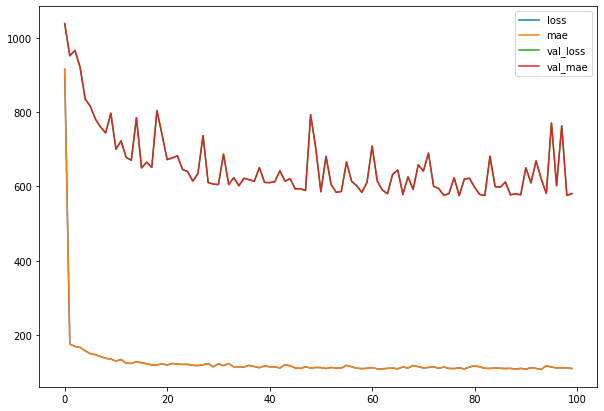

In [62]:
# Evaluate model on test data
model_3.evaluate(test_windows, test_labels)

pd.DataFrame(history_3.history).plot(figsize=(10, 7))

# Load in saved best performing model_1 and evaluate on test data
model_3 = tf.keras.models.load_model("model_experiments/" + model_3.name)
model_3.evaluate(test_windows, test_labels)

# Make predictions using model_1 on the test dataset and view the results
model_3_preds = make_preds(model_3, test_windows)


# Evaluate preds
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results